# IBM stock prediction

## Import all required modules

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from joblib import Parallel, delayed
from collections import deque 
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, LSTM
from keras.layers.core import Dropout, Dense

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = '20'

In [249]:
df = pd.read_csv('./data/2 Year IBM Stock Data.csv', index_col='time')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y %H:%M')

print(df[:5])
df.tail()

                        open    high      low   close  volume
time                                                         
2022-03-25 19:19:00  131.300  131.30  131.300  131.30     718
2022-03-25 19:18:00  131.300  131.30  131.300  131.30     282
2022-03-25 17:50:00  131.300  131.30  131.300  131.30     100
2022-03-25 16:59:00  131.340  131.35  131.340  131.35    1427
2022-03-25 16:42:00  131.326  131.35  131.326  131.35    1326


,open,high,low,close,volume
time,,,,,
2020-04-06 07:27:00,95.385037,95.385037,95.385037,95.385037,854
2020-04-06 07:25:00,94.530379,94.530379,94.530379,94.530379,450
2020-04-06 07:08:00,94.703037,94.703037,94.703037,94.703037,436
2020-04-06 07:02:00,95.479999,95.479999,95.479999,95.479999,575
2020-04-06 07:01:00,94.979290,94.979290,94.979290,94.979290,452


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216883 entries, 2022-03-25 19:19:00 to 2020-04-06 07:01:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    216883 non-null  float64
 1   high    216883 non-null  float64
 2   low     216883 non-null  float64
 3   close   216883 non-null  float64
 4   volume  216883 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 9.9 MB


The dataset begins at *2020-04-06 07:01:00* to 2022-03-25 19:19:00 
and there are no null values.

In [251]:
df.describe()

,open,high,low,close,volume
count,216883.000000,216883.000000,216883.000000,216883.000000,2.168830e+05
mean,118.568888,118.610088,118.527167,118.568678,1.123028e+04
std,11.032437,11.030216,11.034414,11.032587,2.550945e+04
min,93.893379,94.001154,93.878046,93.894886,0.000000e+00
25%,109.270433,109.306157,109.232227,109.272002,3.895500e+03
50%,116.919510,116.953384,116.880199,116.919510,6.786000e+03
75%,129.697796,129.731458,129.666234,129.700000,1.175100e+04
max,140.686324,140.778433,140.363945,140.658692,2.110106e+06


In [252]:
df = df.resample('H').mean().dropna()
df.head()

,open,high,low,close,volume
time,,,,,
2020-04-06 07:00:00,95.117417,95.118202,95.117417,95.118202,498.545455
2020-04-06 08:00:00,94.875700,94.915920,94.829997,94.835583,660.764706
2020-04-06 09:00:00,95.878827,96.046096,95.785695,95.932437,20796.700000
2020-04-06 10:00:00,97.157129,97.248585,97.059121,97.140337,12452.016667
2020-04-06 11:00:00,97.141259,97.212611,97.070626,97.143337,14500.466667


Granularity is in minutes so we resample to change into hours. This takes precedent values to resample then we need to drop news na.

In [253]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

## Data visualization

In [254]:
sample = df.last('3M')

fig = go.Figure(data=[go.Candlestick(x=sample.index,
                open=sample['open'],
                high=sample['high'],
                low=sample['low'],
                close=sample['close'])])

fig.show()

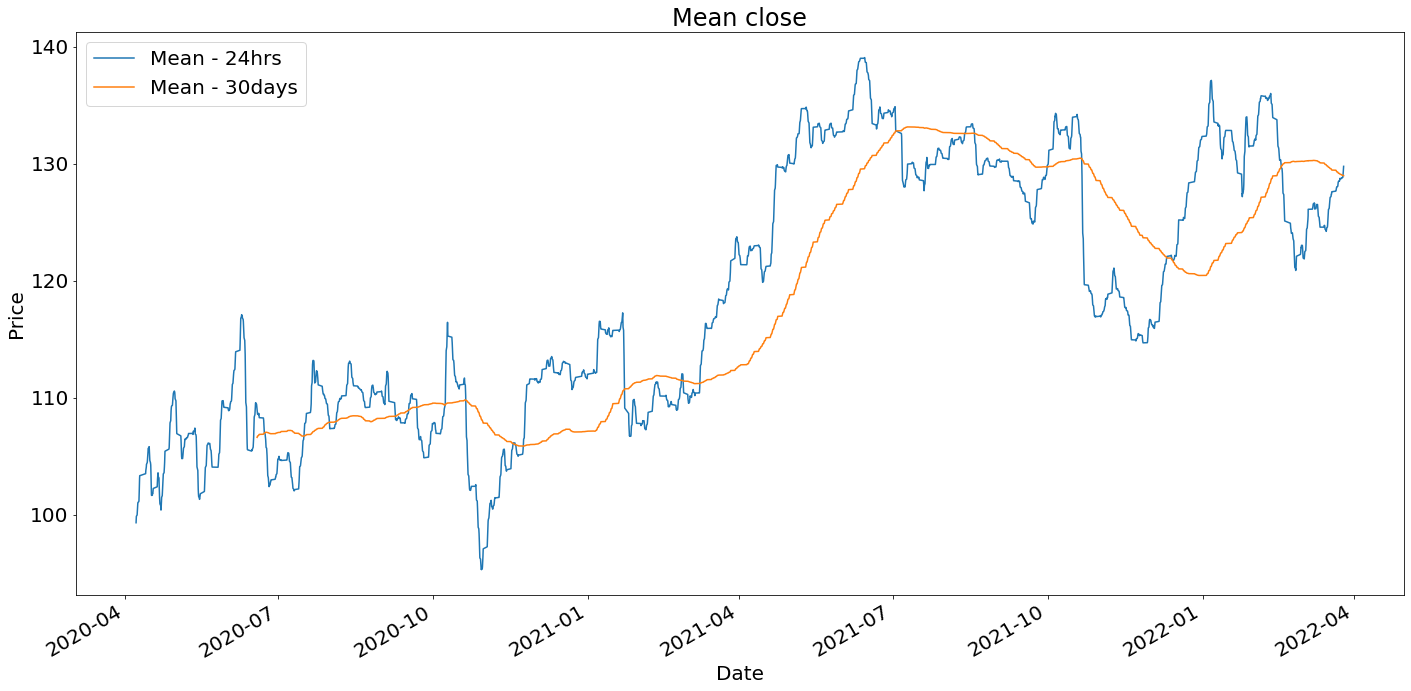

In [255]:
close = df['close']

close.rolling(window=24).mean().plot(label='Mean - 24hrs')
close.rolling(window=24*30).mean().plot(label='Mean - 30days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Mean close')
plt.legend();

What is the risk value by investing in this stock ?

Text(50, 50, 'IBM')

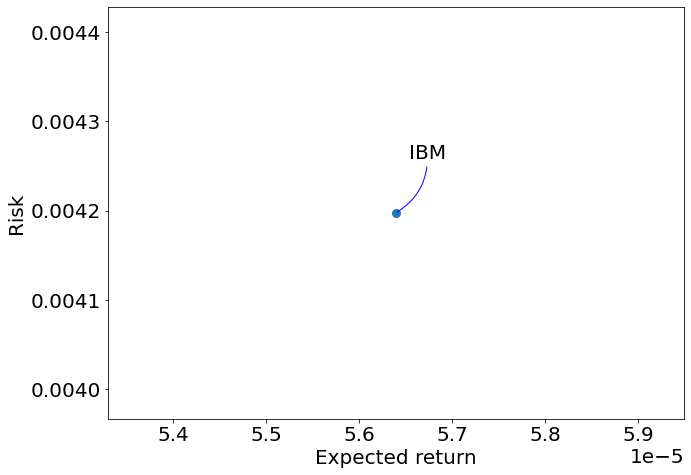

In [256]:
df_change = df['close'].copy().pct_change().dropna()

area = np.pi * 20

plt.figure(figsize=(10, 7))
plt.scatter(df_change.mean(), df_change.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

plt.annotate('IBM', xy=(df_change.mean(), df_change.std()), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

Make a copy that will serve us for the prediction

In [257]:
df_copy = df.iloc[:, 3:4].copy()
df_copy.head()

,close
time,
2020-04-06 07:00:00,95.118202
2020-04-06 08:00:00,94.835583
2020-04-06 09:00:00,95.932437
2020-04-06 10:00:00,97.140337
2020-04-06 11:00:00,97.143337


In [258]:
df_copy['target'] = df_copy['close'].shift(periods=-14)
df_copy.head()

,close,target
time,,
2020-04-06 07:00:00,95.118202,102.578410
2020-04-06 08:00:00,94.835583,102.434529
2020-04-06 09:00:00,95.932437,102.133346
2020-04-06 10:00:00,97.140337,102.550863
2020-04-06 11:00:00,97.143337,101.742143


## Prepare dataset into training and test

In [259]:
def seasonal_bootstrap(df, freq, shift_max=0, n_samples=1, replace=False,
                       n_jobs=1):

    leap_mask = (~((df.index.month == 2) & (df.index.day == 29)))
    new_df = df.copy() #df without leap years
    new_df = new_df[leap_mask]       
    parallel = Parallel(n_jobs=n_jobs)
    
    def create_seasonal_bootstrap(i):
        """
        Returns
        -------
        df_res : pd.DataFrame
            seasonally bootstrapped data
        """
        random.seed(i)
                
        if replace == True:
            index = new_df.index
            blocks = create_blocks(new_df, freq, shift_max)
            #convert list of blocks into array of blocks in order to use indexing
            b = np.empty(len(blocks), dtype=object)
            b[:] = blocks
            blocks = b
            lengths = [len(block) for block in blocks]
            ndays = np.bincount(lengths).argmax()
            blocks_to_shuffle = np.where(lengths == ndays)[0]
            new_indices = np.copy(blocks_to_shuffle)
            new_indices = np.random.choice(new_indices, len(new_indices),
                                           replace=True)
            blocks[blocks_to_shuffle]=blocks[new_indices]
                
        else:
            index = df.index
            blocks = create_blocks(df, freq, shift_max)
            random.shuffle(blocks)
        
        #out-of-bag indices
        
                
        df_res =  pd.concat(blocks)

        if isinstance(df_res, pd.DataFrame):
            df_res.set_index(index, inplace=True)
            
        else:
            df_res.index = index
            
        return df_res
    
    
    return parallel(
            delayed(create_seasonal_bootstrap)(i) for i in range(n_samples)
            )


def create_blocks(df, freq, shift_max=0):
  
    shift = random.randint(-shift_max, shift_max)
    df = df.shift(shift)
    #we retrieve groups through the groupby method            
    blocks = deque([gp[1] for gp in df.groupby(pd.Grouper(freq=freq))])
        
    return blocks


bootstrap_samples = seasonal_bootstrap(df=df_copy,
                                       freq='M',
                                       shift_max=0,
                                       n_samples=6,
                                       replace=True,
                                       n_jobs=1)

Shuffle the dataset with a month frequency

In [260]:
def split_data(df, split_fraction):
    split_size = round(len(df)*split_fraction)
    train = df[:split_size]
    test = df[split_size:]
    return train, test

In [261]:
train_split, test_split = split_data(bootstrap_samples[1], 0.7)

print('train_split.shape', train_split.shape)
print('test_split.shape', test_split.shape)

train_split.shape (4742, 2)
test_split.shape (2032, 2)


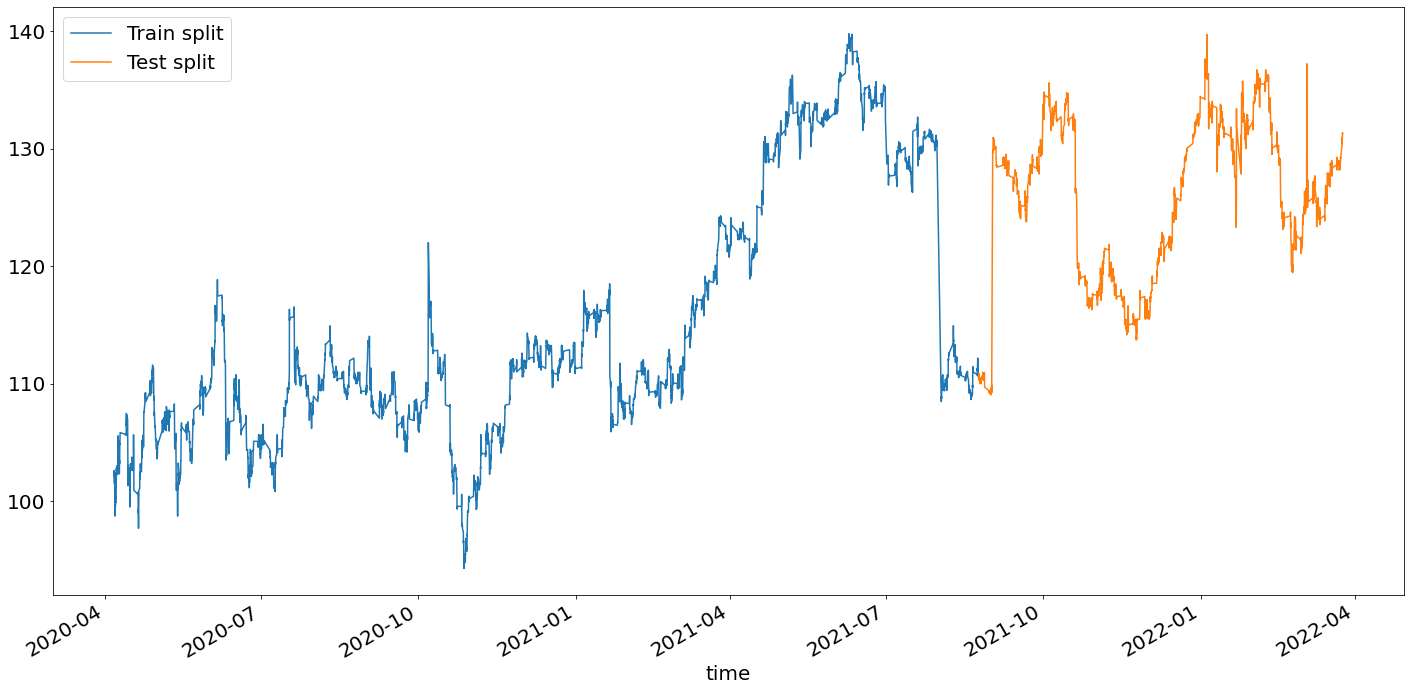

In [262]:
train_split['target'].plot(label='Train split')
test_split['target'].plot(label='Test split')
plt.legend();

In [263]:
scaler_train = MinMaxScaler(feature_range=(0,1))
scaler_train = scaler_train.fit(train_split)

scaled_train = scaler_train.transform(train_split)
scaled_test = scaler_train.transform(test_split)

print('scaled train', scaled_train.shape)
print('scaled test', scaled_test.shape)

scaled train (4742, 2)
scaled test (2032, 2)


In [264]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()

    for i in range( len(sequence) ):
        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X)[:,:,:-1], np.array(y)[:,-1]



X_train, Y_train = split_sequence(scaled_train, 24)
X_test, Y_test = split_sequence(scaled_test, 24)

print(X_train.shape)
print(Y_train.shape)
print("")
print(X_test.shape)
print(Y_test.shape)

(4718, 24, 1)
(4718,)

(2008, 24, 1)
(2008,)


In [265]:
n_input = X_train.shape[1] * X_train.shape[2]
x_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
x_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Create LSTM model

In [318]:
def define_lstm_model(X, Y_train, nb_neuron_dense, epoch):
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(LSTM(nb_neuron_dense, return_sequences=True, input_dim=n_input))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=32))
    model.add(Dropout(0.2))

    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

    history = model.fit(X, Y_train,
                        batch_size=16, epochs=epoch, verbose=1)
    
    return history, model

In [292]:
def plot_val_loss(history):
    plt.plot(pd.DataFrame(history.history)['loss'], label = 'loss')
    plt.legend()
    plt.title("Number epoch: " +  str(len(pd.DataFrame(history.history))))
    return pd.DataFrame(history.history)

In [293]:
def rescale_pred(X_test, Y_test_predicted, Y_test):
    concat_predict = np.concatenate( (X_test[:,0,:], Y_test_predicted), 1 )
    concat_real = np.concatenate( (X_test[:,0,:], Y_test.reshape( Y_test.shape[0], 1 )), 1 )

    Y_test_predicted_rescaled = scaler_train.inverse_transform(concat_predict)
    Y_test_real_rescaled = scaler_train.inverse_transform(concat_real)

    total = pd.concat([pd.DataFrame(Y_test_real_rescaled).iloc[:,-1],
                       pd.DataFrame(Y_test_predicted_rescaled).iloc[:,-1]],1)
    total.columns = ['Real', 'Predicted']
    
    return total

In [294]:
def error(df_actual, df_predicted):
    mse = mean_squared_error(df_actual, df_predicted, squared=True)
    rmse  = mean_squared_error(df_actual, df_predicted, squared=False)
    mae =  mean_absolute_error(df_actual, df_predicted)

    errorS = pd.DataFrame([mse, rmse, mae], index=['MSE','RMSE','MAE'])
    
    return errorS

Epoch 1/20
295/295 [==============================] - 4s 5ms/step - loss: 0.0254 - accuracy: 4.2391e-04
Epoch 2/20
295/295 [==============================] - 1s 4ms/step - loss: 0.0134 - accuracy: 4.2391e-04
Epoch 3/20
295/295 [==============================] - 1s 4ms/step - loss: 0.0116 - accuracy: 4.2391e-04
Epoch 4/20
295/295 [==============================] - 1s 4ms/step - loss: 0.0110 - accuracy: 4.2391e-04
Epoch 5/20
295/295 [==============================] - 1s 4ms/step - loss: 0.0099 - accuracy: 4.2391e-04
Epoch 6/20
295/295 [==============================] - 1s 4ms/step - loss: 0.0095 - accuracy: 4.2391e-04
Epoch 7/20
295/295 [==============================] - 1s 4ms/step - loss: 0.0086 - accuracy: 4.2391e-04
Epoch 8/20
295/295 [==============================] - 1s 4ms/step - loss: 0.0088 - accuracy: 4.2391e-04
Epoch 9/20
295/295 [==============================] - 1s 4ms/step - loss: 0.0085 - accuracy: 4.2391e-04
Epoch 10/20
295/295 [==============================] - 1s 4ms/st

,loss,accuracy
0,0.025417,0.000424
1,0.013373,0.000424
2,0.011636,0.000424
3,0.010967,0.000424
4,0.009859,0.000424
5,0.009509,0.000424
6,0.008605,0.000424
7,0.008785,0.000424
8,0.008458,0.000424
9,0.008224,0.000424


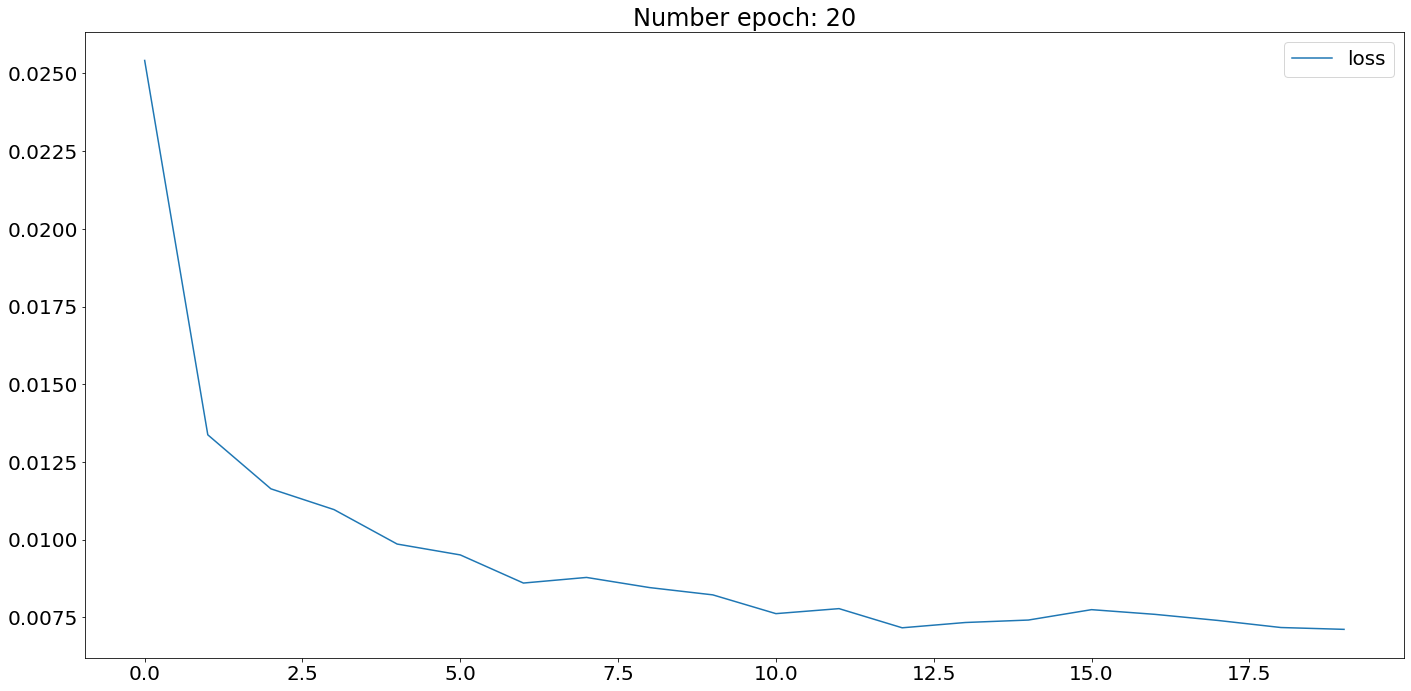

In [322]:
history, model = define_lstm_model(x_train_reshape, Y_train,
                                nb_neuron_dense=128,
                                epoch = 20)

plot_val_loss(history)

/tmp/ipykernel_248/3135195580.py:9: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.



       MSE      RMSE      MAE
0  4.52981  2.128335  1.52048


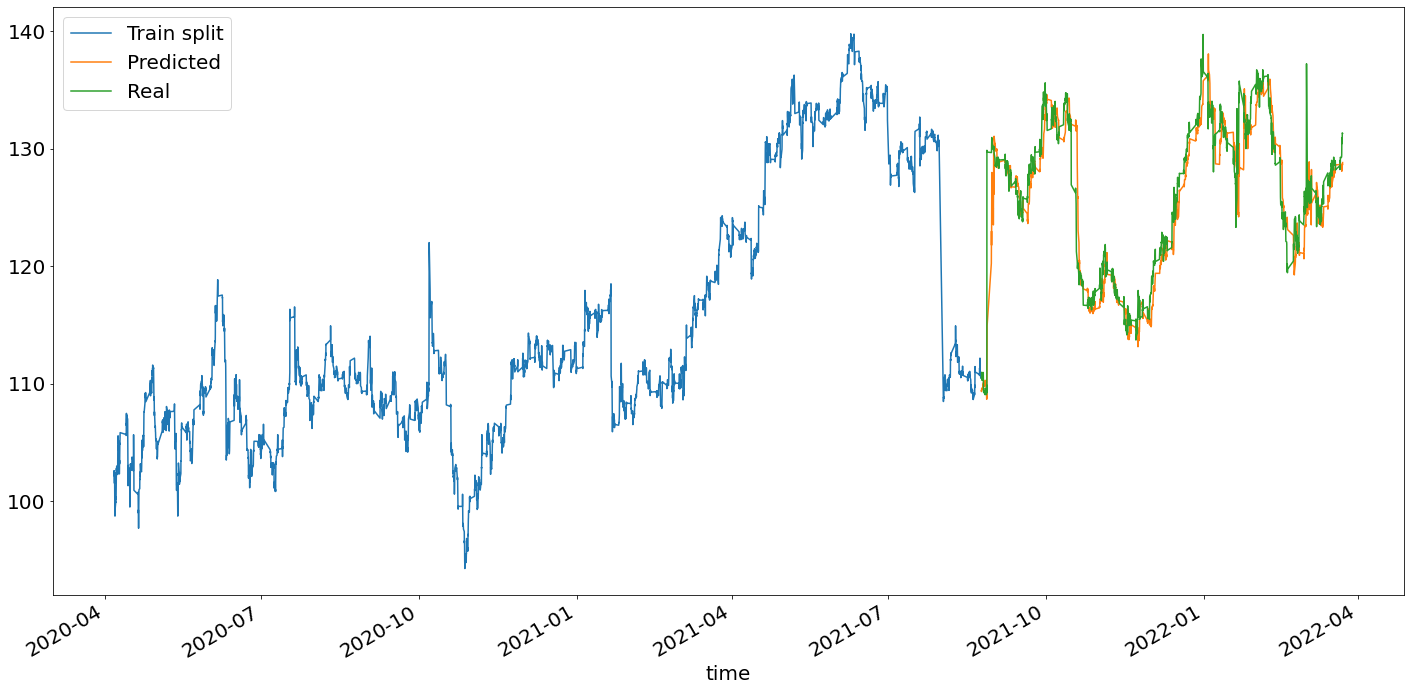

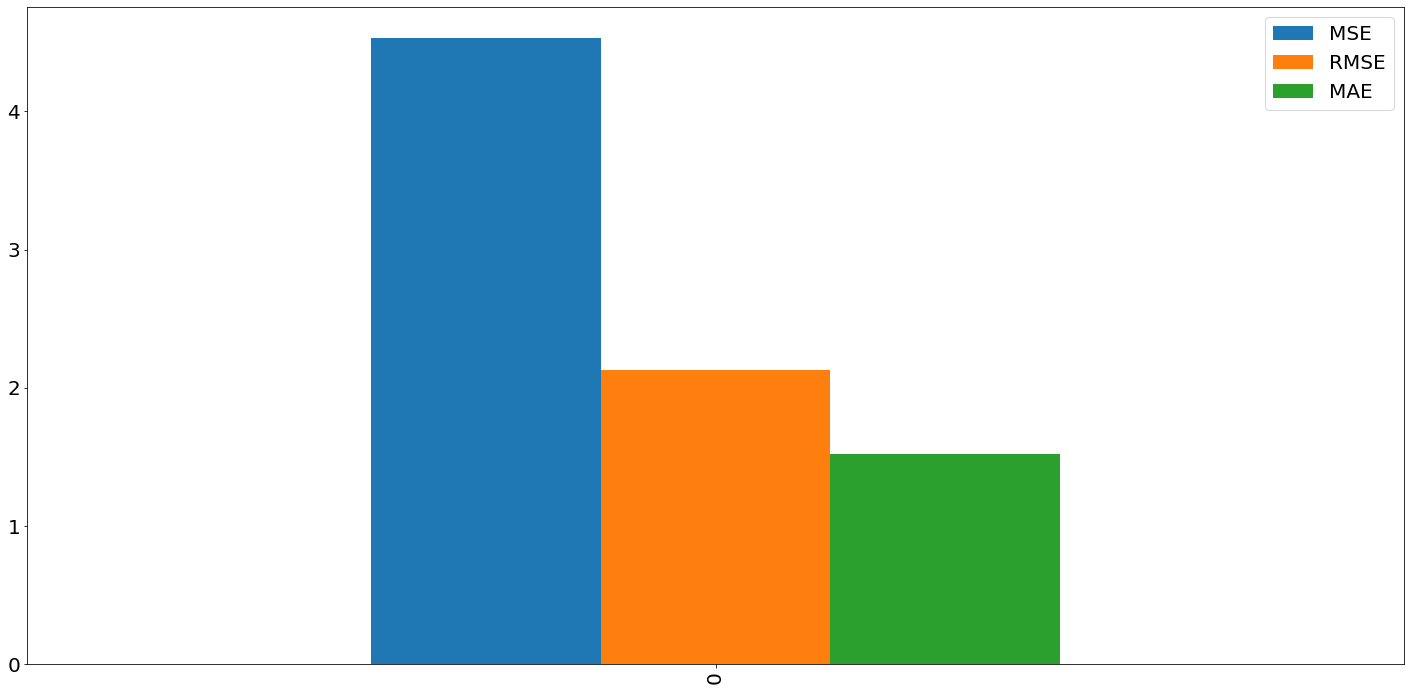

In [323]:
Y_test_predicted = model.predict(x_test_reshape, verbose=0)

concat_predict = np.concatenate( (X_test[:,0,:], Y_test_predicted), 1 )
Y_test_predicted_rescaled = scaler_train.inverse_transform(concat_predict)

concat_real = np.concatenate( (X_test[:,0,:], Y_test.reshape(Y_test.shape[0],1)), 1 )
Y_test_real_rescaled = scaler_train.inverse_transform(concat_real)

df_predicted = pd.concat([ pd.DataFrame( Y_test_predicted_rescaled[:,-1] ), pd.DataFrame( Y_test_real_rescaled[:,-1] ) ], 1)
df_predicted.columns = ["Predicted",'Real']
df_predicted.index = test_split[:-24].index
df_predicted = df_predicted.dropna()

train_split['target'].plot(label='Train split')
df_predicted['Predicted'].plot(label='Predicted')
df_predicted['Real'].plot(label='Real')
plt.legend();


errorS = pd.DataFrame(error(df_predicted['Real'], df_predicted['Predicted'])).T
errorS.columns=['MSE','RMSE','MAE']
errorS.plot.bar()
print(errorS)
plt.show()

In [325]:
model.save('models/ibm_model.h5')